# overview of DriXMed22 campaign


In [1]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

# drixmed utils
#import utils as ut

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


---
## load data

In [2]:
campaign = "drixmed22"
root_dir = "/Users/aponte/Code/drix_analysis/" + campaign
yaml = f"{campaign}.yaml"

# load campaign object
cp = pin.campaign(os.path.join(root_dir, yaml))

# plotting utils
kwargs_map = dict(extent=cp.lon + cp.lat, bathy=cp.bathy["label"])

underway
tide_gauge
adcp_europe
adcp_drix
ctd_europe
ctd_drix
0-4350125
0-4352044
0-4350124
0-4352185
0-4351896
0-4352181


In [4]:
# europe
europe = cp.load("europe_underway_10s.nc").set_coords(["lon", "lat"])

# drix
drix = cp.load("drix_underway_ctd_10s.nc").set_coords(["lon", "lat"])
drix_met = cp.load("drix_met_10s.nc")
drix_ins = cp.load("drix_ins_10s.nc").sortby("time")

# ctd
u = "ctd_europe"
ctd = {d.label: cp.load(f"{u}_{d.label}.nc") for d in cp[u]}

# merge into one dataset
# ds = xr.concat([ds for d, ds in D.items()], "cast")

# meteo
arome = cp.load("met_arome.nc")

# load drifters
dr = cp.load("drifters.nc").to_dataframe()

In [5]:
# interpolate arome on DriX trajectory
# _u10 = arome.u10m.interp(longitude=europe_underway.long, latitude=europe_underway.long, time=europe_underway.time)
# arome["u10m"].isel(longitude=10, latitude=10).plot()

---
## time line

Need to add wind and 

-12 -12.4


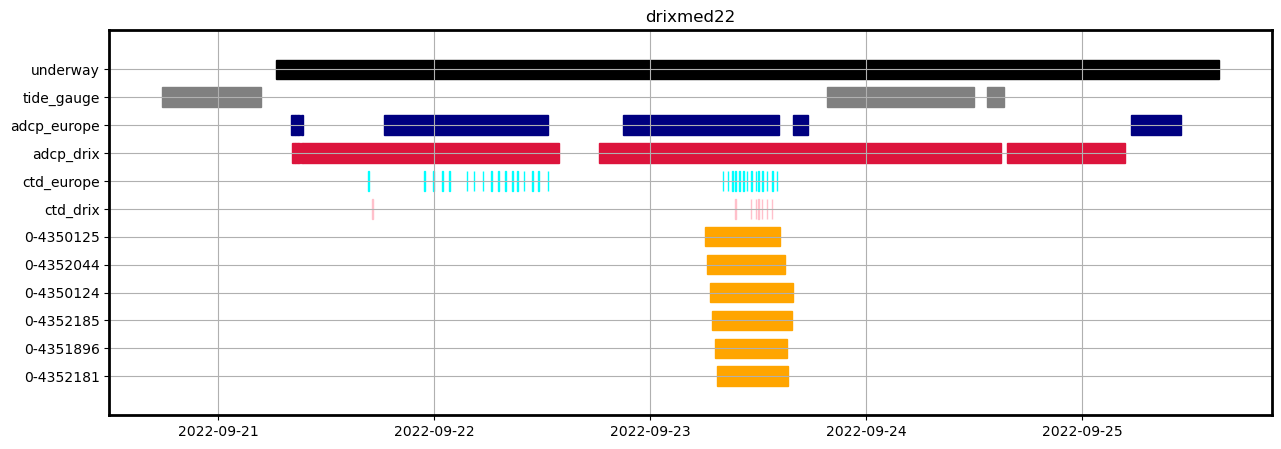

In [6]:
ax = cp.timeline(height=0.7, legend=None)
# ax.get_ylim()
ax.grid()

with wind

-12 -12.4


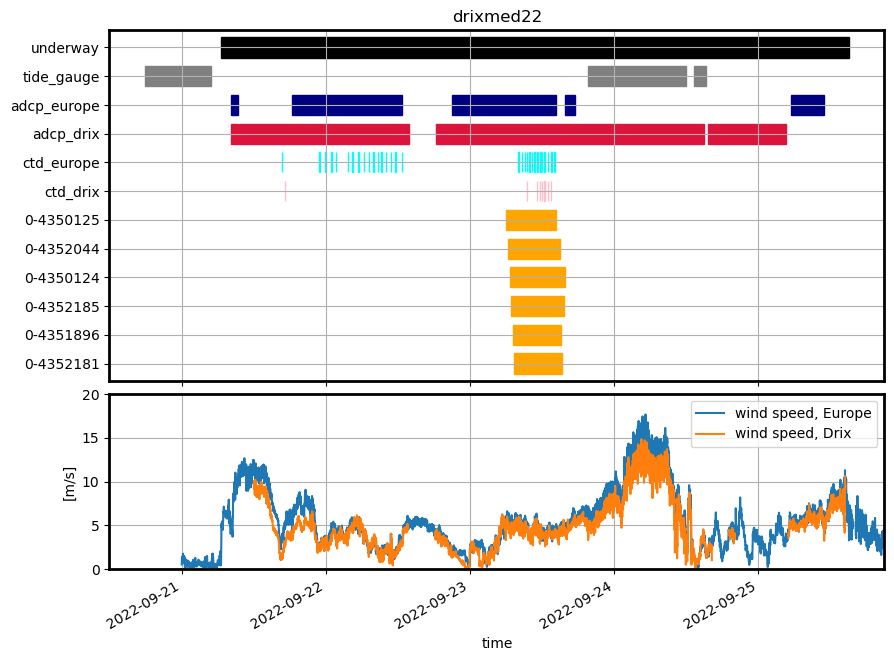

In [7]:
gs_kw = dict(
    width_ratios=[
        1,
    ],
    height_ratios=[2, 1],
    hspace=0.05,
)
fig, axd = plt.subplot_mosaic(
    [["top"], ["bottom"]],
    gridspec_kw=gs_kw,
    figsize=(10, 7),
    sharex=True,
    # layout="constrained",
)
# fig.suptitle('plt.subplot_mosaic()')

cp.timeline(legend=None, height=0.7, ax=axd["top"])
axd["top"].grid()
axd["top"].set_ylim(-11.6, 0.6)

ax = axd["bottom"]
_speed = europe["trueairspeed"]
_speed = _speed.resample(time="1T").mean()
_speed.plot(ax=ax, label="wind speed, Europe")

_speed, _heading = pin.uv2speedheading(drix_met.wind_u_true, drix_met.wind_v_true)
_speed = _speed.resample(time="1T").mean()
_speed.plot(ax=ax, label="wind speed, Drix")


ax.set_ylim(0, 20)
ax.grid()
ax.set_ylabel("[m/s]")
ax.legend()

---
## meteo overview

array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>],
      dtype=object)

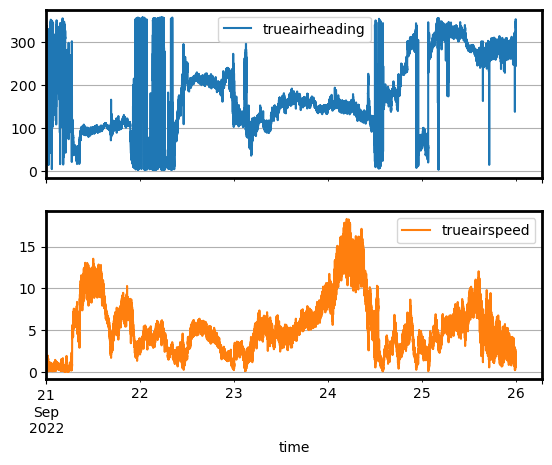

In [9]:
europe.to_pandas()[["trueairheading", "trueairspeed"]].plot(
    subplots=True, grid=True
)

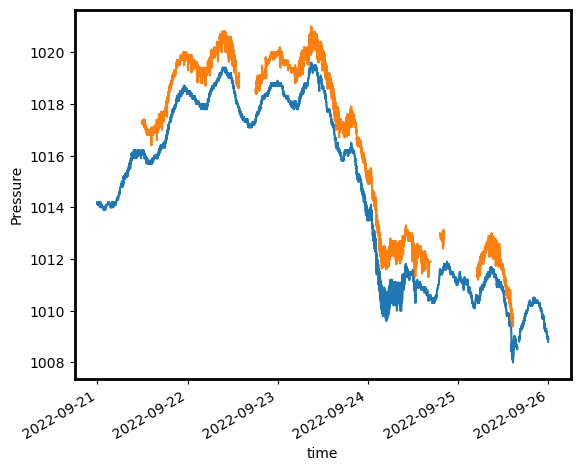

In [10]:
europe.airpressure.plot(label="europe")
drix_met.Pressure.plot(label="drix")

In [11]:
rho_air = 1  # kg/m^3
dz = 10  # m
g = 9.81  # m/s^2
rho_air * g * dz / 100  # mbar

0.9810000000000001

---
## underway overview

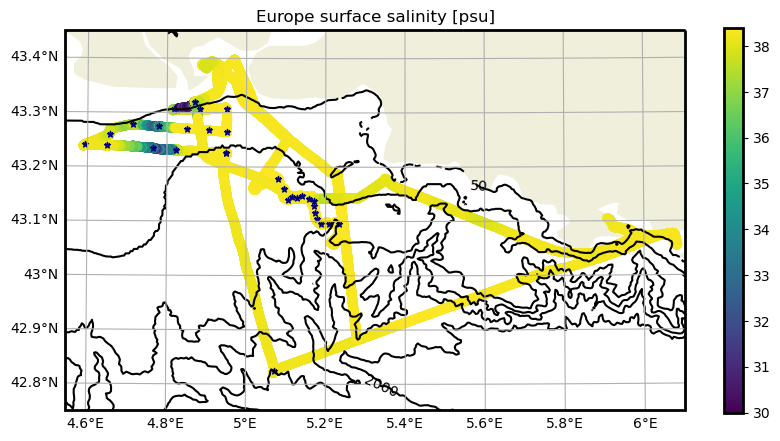

In [13]:
da = europe.salinity

fac = pin.maps.plot_map(**kwargs_map, bathy_levels=cp.bathy["levels"])
fig, ax = fac["fig"], fac["ax"]
im = ax.scatter(da.lon, da.lat, c=da, transform=crs, vmin=30)
fig.colorbar(im, ax=ax)
ax.set_title("Europe surface salinity [psu]")


ax.scatter(
    [d.start.lon for d in cp["ctd_europe"]],
    [d.start.lat for d in cp["ctd_europe"]],
    s=20,
    c="navy",
    edgecolor=None,
    marker="*",
    transform=crs,
)

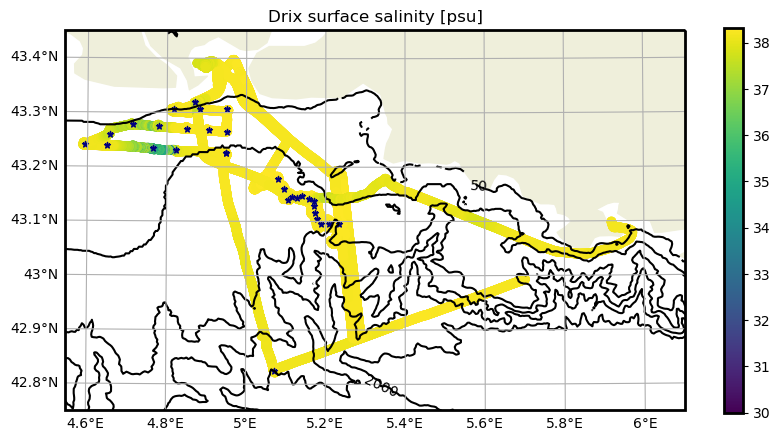

In [14]:
da = drix.salinity

fac = pin.maps.plot_map(**kwargs_map, bathy_levels=cp.bathy["levels"])
fig, ax = fac["fig"], fac["ax"]
im = ax.scatter(da.lon, da.lat, c=da, transform=crs, vmin=30)
fig.colorbar(im, ax=ax)
ax.set_title("Drix surface salinity [psu]")


ax.scatter(
    [d.start.lon for d in cp["ctd_europe"]],
    [d.start.lat for d in cp["ctd_europe"]],
    s=20,
    c="navy",
    edgecolor=None,
    marker="*",
    transform=crs,
)

### Plot overview of both campaigns along with sea level and wind

Text(0, 0.5, '[m/s]')

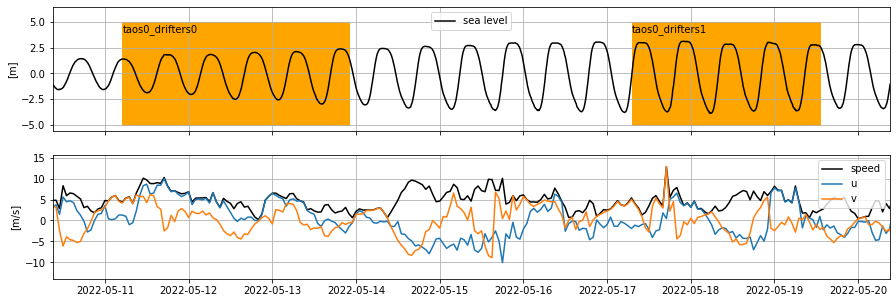

In [56]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(2, 1, figsize=(15, 5))

height = 10
y = 0
starts, ends = [], []

ax = axes[0]

for cpg in ["taos0_drifters0", "taos0_drifters1"]:
    yaml = cpg.split("_")[-1] + f"/{cpg}.yaml"
    _cp = pin.campaign(os.path.join(root_dir, yaml), verbose=False)
    # print(_cp)

    start = mdates.date2num(_cp.start)
    end = mdates.date2num(_cp.end)
    rect = Rectangle((start, y - height / 2.0), end - start, height, color="orange")
    ax.add_patch(rect)
    starts.append(start)
    ends.append(end)
    # print(start, end-start)
    ax.text(start, y + height * 0.4, cpg)

# sea level
_mtime = slvl.index.map(lambda t: mdates.date2num(t))
_slvl = slvl.sea_level.values
ax.plot(_mtime, _slvl, color="k", label="sea level")

delta_time = max(ends) - min(starts)


def _set_axis(ax, xticklabels=True):

    ax.set_xlim(min(starts) - 0.1 * delta_time, max(ends) + 0.1 * delta_time)
    locator = mdates.AutoDateLocator(minticks=3)
    formatter = mdates.AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    if not xticklabels:
        ax.set_xticklabels([])
    ax.grid()
    ax.legend()


_set_axis(
    ax,
    xticklabels=False,
)
ax.set_ylabel("[m]")

###
ax = axes[1]

# wind
_mtime = mdates.date2num(wind.time)
lon, lat = cp["0-4351908"]["d0"].start.lon, cp["0-4351908"]["d0"].start.lat
_w = wind.sel(longitude=lon, latitude=lat, method="nearest")
_uv10 = np.sqrt(_w.u10m**2 + _w.v10m**2)
ax.plot(_mtime, _uv10, color="k", label="speed")
ax.plot(_mtime, _w.u10m, label="u")
ax.plot(_mtime, _w.v10m, label="v")

ax.legend()

_set_axis(ax)
ax.set_ylabel("[m/s]")

---

### maps

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


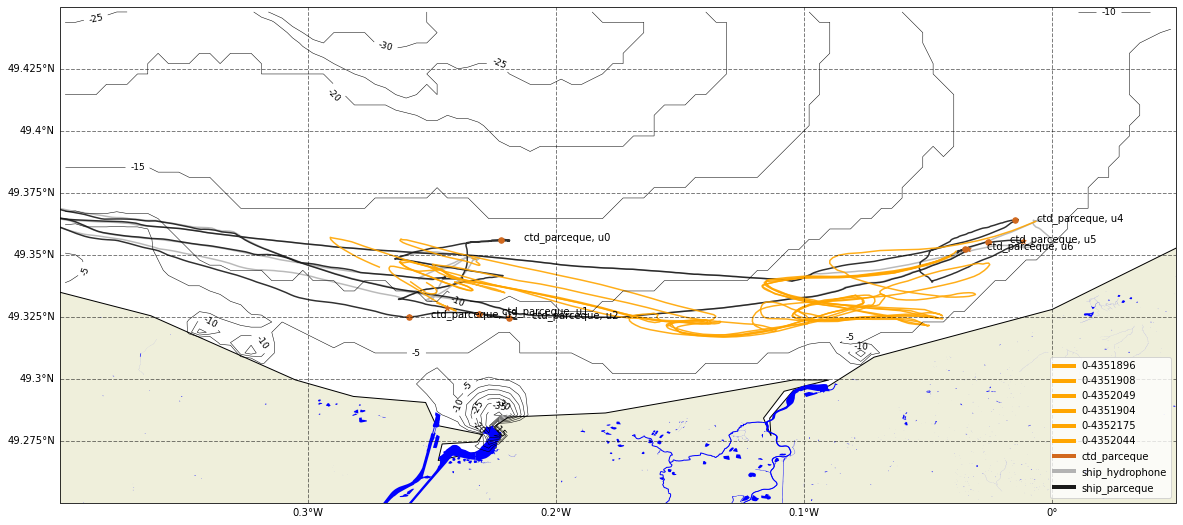

In [5]:
fig, ax, crs = cp.plot_map(coast="bseine", land=None, rivers="bseine", figsize=(20, 10))

for uname, unit in cp.items():
    if "ship" in uname:
        s = ship[uname]
        for d, df in s.items():
            ax.plot(
                df.longitude,
                df.latitude,
                color=cp[uname]["color"],
                alpha=0.9,
                transform=crs,
                label=uname + ", " + d,
                zorder=0,
            )
        continue
    if "ctd" in uname and False:
        c = ctd[uname]
        for d, df in c.items():
            ax.plot(
                df.longitude,
                df.latitude,
                color=cp[uname]["color"],
                alpha=0.9,
                transform=crs,
                label=uname + ", " + d,
                zorder=1,
            )
        continue
    if "0-4" in uname:
        _df = dr.loc[uname]
        for d in _df["deployment"].unique():
            _dfd = _df.loc[_df.deployment == d].sort_values("time").set_index("time")
            ax.plot(
                _dfd.longitude,
                _dfd.latitude,
                color=cp[uname]["color"],
                alpha=0.9,
                transform=crs,
                label=uname + ", " + d,
                zorder=1,
            )
        continue

    for d in unit:
        line = False
        yshift = 0.0
        label = uname + ", " + d.label
        # if unit=='ctd':
        #    line=False
        # else:
        #    line=True
        # if unit=='source':
        #    yshift=2
        # else:
        #    yshift=0.
        d.plot_on_map(ax, line=line, label=label, color=unit["color"], yshift=yshift)

cp.add_legend(ax, loc=4)

In [6]:
# store bathymetric contours prior to folium plots
if False:
    pin.store_bathy_contours(
        cp.bathy["label"],
        os.path.join(cp.pathp, "bathy_contours.geojson"),
        levels=cp.bathy["levels"],
    )

In [ ]:
# cp.map(overwrite_contours=True)
# cp.map(zoom=11, ignore=["ship_hydrophone", "ship_parceque"])

### surface drifters

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


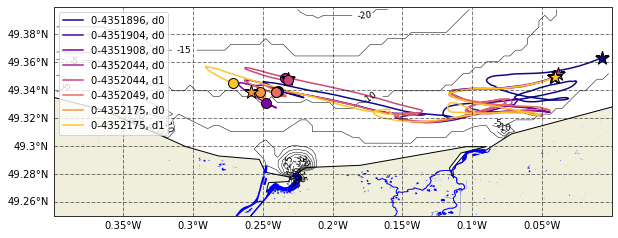

In [6]:
# bounds=[-.5, -.1, 49.25, 49.5]
if campaign == "taos0_drifters0":
    bounds = [-0.4, 0.0, 49.25, 49.4]  # taos0-drifters0
elif campaign == "taos0_drifters1":
    bounds = [-0.45, -0.15, 49.25, 49.45]  # taos0-drifters1

_df = dr.reset_index().set_index(["id", "deployment"])

fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index().dropna(axis=1)
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))
    ax.scatter(
        _dfk.longitude.iloc[0],
        _dfk.latitude.iloc[0],
        color=c,
        transform=crs,
        edgecolor="k",
        s=100,
        zorder=10,
        marker="o",
    )
    ax.scatter(
        _dfk.longitude.iloc[-1],
        _dfk.latitude.iloc[-1],
        color=c,
        transform=crs,
        edgecolor="k",
        s=200,
        zorder=10,
        marker="*",
    )

ax.legend()

---

## movie


In [4]:
kwargs_map

{'extent': (4.55, 6.1, 42.75, 43.45),
 'bathy': '/Users/aponte/Data/bathy/med_gebco0/gebco_2022_n43.932_s41.3124_w2.0025_e7.6744.nc'}

In [6]:
def make_movie(
    cp,
    tstart,
    tend,
    drifters=None,
    ship=False,
    wind=None,
    ctd=None,
    bounds=None,
    istart=None,
    dt="10T",
    del_t="1H",  # trail behing ships
    wind_arrow_scale=1,
    wind_di=4,
    wind_offset=0,
):
    """Make a movie"""

    from tqdm import tqdm

    t_range = pd.date_range(tstart, tend, freq=dt)
    del_t = pd.Timedelta(del_t)

    _kwargs_map = dict(**kwargs_map)
    if isinstance(bounds, float):
        _kwargs_map["figsize"] = (7, 7)

    plt.switch_backend("agg")

    # fig_dir = os.path.join(cp.pathp, 'figs/')
    fig_dir = "/Users/aponte/tmp/figs/"

    europe_col = cp["adcp_europe"]["color"]
    drix_col = cp["adcp_drix"]["color"]

    i = -1
    for t in tqdm(t_range):
        i += 1

        if i < istart:
            continue

        _ds = europe.sel(time=t, method="nearest")
        if isinstance(bounds, float) and _ds.time.size > 0:
            _ds = europe.sel(time=t, method="nearest")
            lon, lat = float(_ds["lon"]), float(_ds["lat"])
            dlon = bounds / np.cos(lat * pin.deg2rad) * 0.5
            dlat = bounds * 0.5
            _kwargs_map["extent"] = [lon - dlon, lon + dlon, lat - dlat, lat + dlat]
        fac = pin.maps.plot_map(**_kwargs_map, bathy_levels=cp.bathy["levels"])
        fig, ax = fac["fig"], fac["ax"]
        # fig, ax, crs = cp.plot_map(figsize=(10,10), bounds=bounds,
        #                           coast="bseine", land=None, rivers="bseine",
        # )

        # ship
        if ship:
            # europe
            _ds = europe.sel(time=slice(t - del_t, t))
            ax.plot(
                _ds["lon"], _ds["lat"], lw=3, color=europe_col, alpha=1, transform=crs
            )
            ax.scatter(
                _ds["lon"][-1],
                _ds["lat"][-1],
                s=10,
                c="0.7",
                marker="o",
                edgecolors="k",
                linewidths=0.5,
                transform=crs,
                zorder=10,
            )
            # drix
            # _ds = drix.sel(time=slice(t-del_t,t))
            # ax.plot(_ds['lon'], _ds['lat'], lw=1, color=drix_col, alpha=.8, transform=crs)
            _ds = drix_ins.sel(time=slice(t - del_t, t))
            ax.plot(
                _ds["longitude"],
                _ds["latitude"],
                lw=1,
                color=drix_col,
                alpha=1,
                transform=crs,
            )
            if _ds.time.size > 0:
                ax.scatter(
                    _ds["longitude"][-1],
                    _ds["latitude"][-1],
                    s=10,
                    c="0.7",
                    marker="o",
                    edgecolors="k",
                    linewidths=0.5,
                    transform=crs,
                    zorder=10,
                )

        # wind
        if wind is not None:
            qkwargs = dict(
                scale=2e2 / wind_arrow_scale,
                width=2e-3 * wind_arrow_scale,
                transform=crs,
                zorder=1,
                add_guide=False,
            )
            #
            _di = wind_di
            _ds = wind.interp(time=t).isel(
                longitude=slice(0, None, _di), latitude=slice(0, None, _di)
            )
            q = _ds.plot.quiver(
                x="longitude", y="latitude", u="u10m", v="v10m", color="0.5", **qkwargs
            )
            qk = ax.quiverkey(
                q,
                0.1,
                0.9,
                10,
                "10 m/s",
                transform=crs,
                color="0.5",
                labelpos="W",
                coordinates="axes",
                zorder=100,
            )
            # europe wind
            _ds = europe.interp(time=t).expand_dims(dict(dum=2))
            _ds["wind_u_true"], _ds["wind_v_true"] = pin.speedheading2uv(
                _ds.trueairspeed, _ds.trueairheading
            )
            _ds["lat"] = _ds["lat"] + wind_offset
            q = _ds.plot.quiver(
                x="lon",
                y="lat",
                u="wind_u_true",
                v="wind_v_true",
                color=europe_col,
                **qkwargs,
            )
            # drix wind
            _ds = drix_met.interp(time=t).expand_dims(dict(dum=2))
            _ds["lat"] = _ds["lat"] + wind_offset
            q = _ds.plot.quiver(
                x="lon",
                y="lat",
                u="wind_u_true",
                v="wind_v_true",
                color=drix_col,
                **qkwargs,
            )

        # drifters
        if drifters is not None:
            # ids = dr.index.unique()
            ids = [
                u for u in cp if "0-435" in u
            ]  # prefered as if leads to correct color ordering in legend
            colors = pin.get_cmap_colors(len(ids))
            for idx, c in zip(ids, colors):
                df = dr.loc[idx]
                for d in df["deployment"].unique():
                    _df = (
                        df.loc[df.deployment == d]
                        .set_index("time")
                        .resample("1s")
                        .interpolate()
                    )
                    _df = _df.loc[t - del_t : t]
                    if _df.index.size > 0:
                        ax.plot(
                            _df.longitude,
                            _df.latitude,
                            color=c,  # cp[idx]["color"]
                            transform=crs,
                            label=f"{idx}, {d}",
                            lw=2,
                        )
                        ax.plot(
                            _df.longitude[-1],
                            _df.latitude[-1],
                            color=c,  # cp[idx]["color"]
                            marker="*",
                            markeredgecolor="k",
                            markeredgewidth=0.5,
                            transform=crs,
                            label=f"{idx}, {d}",
                            lw=2,
                            markersize=10,
                        )

        # add pool of isolated events

        # cp.add_legend(ax, loc=4, colors={idx: c for idx, c in zip(ids, colors)})
        ax.set_title(cp.name + "  " + str(t))

        figname = os.path.join(fig_dir, "fig_t%05d" % (i) + ".png")
        _ = fig.savefig(figname, dpi=150, facecolor="w")  # bbox_inches = 'tight'
        _ = fig.clf()


import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [7]:
part = "drifters"

# bounds, istart = None, 0,
bounds, istart = 0.25, 0
dt = "5T"

if part == "all":
    tstart = cp.start
    # tstart = '2022-05-11 05:00:00'
    tend = cp.end
    # dev
    # tstart = cp.start + pd.Timedelta("9H")
    # tend = cp.start + pd.Timedelta("10H") # dev
    # tend = '2022-05-13 10:00:00'
    # bounds = [-.3, .05, 49.25, 49.45]
elif part == "drifters":
    tstart = "2022-09-23 05:30:00"
    tend = "2022-09-23 16:10:00"
    bounds = 0.1
    dt = "30s"

kwargs = dict(
    drifters=dr,
    ship=True,
    wind=arome,
    bounds=bounds,
    istart=istart,
    dt=dt,
    del_t="1H",
)
kwargs.update(wind_arrow_scale=3, wind_di=2, wind_offset=0.02)

# dr = None
make_movie(cp, tstart, tend, **kwargs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1281/1281 [1:04:09<00:00,  3.01s/it]


,time,GPS Confidence,GPS Fail Counter,GpsQuality,latitude,longitude,x,y,ux,uy,velocity,deployment
id,,,,,,,,,,,,
0-4350124,2022-09-23 06:20:00,0.00,0.0,3.0,43.064599,5.218924,20013.737225,-36336.401039,-1.205319,-0.575746,1.335768,d0
0-4350124,2022-09-23 06:40:00,0.00,0.0,3.0,43.065766,5.211318,19393.803576,-36208.539314,-0.516611,0.106551,0.527485,d0
0-4350124,2022-09-23 07:00:00,0.00,0.0,3.0,43.073264,5.206570,19004.766992,-35376.583200,-0.324197,0.693297,0.765352,d0
0-4350124,2022-09-23 07:20:00,0.00,0.0,3.0,43.079163,5.201388,18580.937918,-34722.488417,-0.353191,0.545079,0.649504,d0
0-4350124,2022-09-23 07:40:00,0.00,0.0,3.0,43.085006,5.195074,18065.054223,-34074.657962,-0.429903,0.539859,0.690119,d0
...,...,...,...,...,...,...,...,...,...,...,...,...
0-4352185,2022-09-23 14:00:00,0.00,0.0,3.0,43.151330,5.073039,-13534.704878,1641.018505,-0.521198,0.327055,0.615315,d0
0-4352185,2022-09-23 14:20:00,0.25,0.0,3.0,43.154804,5.064102,-14260.855785,2028.393141,-0.605126,0.322812,0.685846,d0
0-4352185,2022-09-23 14:40:00,0.00,0.0,3.0,43.157722,5.055664,-14946.436583,2354.039606,-0.571317,0.271372,0.632492,d0


In [40]:
def make_movie(
    cp,
    drifters=None,
    wind=None,
    istart=0,
):
    """Make a movie"""

    from tqdm import tqdm

    plt.switch_backend("agg")
    fig_dir = os.path.join(cp.pathp, "figs/")

    del_t = pd.Timedelta("2H")

    dl = 5e3
    xlims = (-dl, dl)
    ylims = (-dl, dl)

    i = -1
    for t in tqdm(drifters.time):
        i += 1

        if i < istart:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        ds = drifters.sel(time=slice(t - del_t, t))

        # wind
        if wind is not None:
            _di = 2
            _ds = wind.interp(time=t).isel(
                longitude=slice(0, None, _di), latitude=slice(0, None, _di)
            )
            q = _ds.plot.quiver(
                x="longitude",
                y="latitude",
                u="u10m",
                v="v10m",
                scale=1e2,
                transform=crs,
                zorder=-2,
            )
            qk = ax.quiverkey(
                q,
                0.1,
                0.9,
                10,
                "10 m/s",
                transform=crs,
                color="r",
                labelpos="W",
                coordinates="axes",
                zorder=10,
            )

        # drifters
        # ids = dr.index.unique()
        ids = [
            u for u in cp if "0-435" in u
        ]  # prefered as if leads to correct color ordering in legend
        colors = pin.get_cmap_colors(len(ids))
        for idx, c in zip(ids, colors):
            _ds = ds.sel(id=idx)
            if _ds.time.size > 0:
                ax.plot(_ds.x_prime, _ds.y_prime, color=c, lw=2)

        ax.set_xlim(*xlims)
        ax.set_ylim(*ylims)
        ax.set_aspect("equal")
        ax.grid()

        cp.add_legend(ax, loc=4, colors={idx: c for idx, c in zip(ids, colors)})
        ax.set_title(cp.name + "  " + str(t.values))

        figname = fig_dir + "fig_t%05d" % (i) + ".png"
        _ = fig.savefig(figname, dpi=150, facecolor="w", bbox_inches="tight")
        _ = fig.clf()


import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
### taos0 - drifters0
bounds, istart = None, 0
if campaign == "taos0_drifters0":
    tstart = "2022-05-11 05:00:00"
    tend = "2022-05-11 09:00:00"
    # tend = '2022-05-13 10:00:00'
elif campaign == "taos0_drifters1":
    tstart = "2022-05-17 08:00:00"
    # tend = '2022-05-17 09:00:00'
    tend = "2022-05-19 13:30:00"
    # istart = 315

make_movie(cp, ds)